# SCA using hamming weight for classification.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras.backend import clear_session
from sklearn.utils import shuffle
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *

from src.aes.sbox import s_box
from src.data.preprocess.hw import hamming_weights
from src.dlla.hw import prepare_traces_dl
from src.pollution.tools import file_suffix
from src.tools.plotter import init_plots
from src.trace_set.database import Database
from src.trace_set.pollution import PollutionType, Pollution
from src.trace_set.set_hw import TraceSetHW

init_plots()

In [2]:
def mlp(classes, number_of_samples):
    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape=(number_of_samples,)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(classes, activation='softmax'))
    model.summary()
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

### Guessing entropy

Example from [here]() TODO

In [3]:
def aes_labelize_ge_sr(attack_plaintext, key_hypothesis):
    key_byte = np.full(len(attack_plaintext), key_hypothesis)
    state = [int(x) ^ int(k) for x, k in zip(np.asarray(attack_plaintext), key_byte)]
    intermediate_values = s_box[state]

    return hamming_weights(intermediate_values)

# guessing entropy and success rate
def compute_ge(runs, model, correct_key, x_attack, attack_plaintext, key_rank_report_interval, key_rank_attack_traces):
    nt = len(x_attack)
    nt_interval = int(key_rank_attack_traces / key_rank_report_interval)
    key_ranking_sum = np.zeros(nt_interval)

    # ---------------------------------------------------------------------------------------------------------#
    # compute labels for key hypothesis
    # ---------------------------------------------------------------------------------------------------------#
    labels_key_hypothesis = np.zeros((256, nt))
    for key_byte_hypothesis in range(0, 256):
        labels_key_hypothesis[key_byte_hypothesis] = aes_labelize_ge_sr(attack_plaintext, key_byte_hypothesis)

    # ---------------------------------------------------------------------------------------------------------#
    # predict output probabilities for shuffled test or validation set
    # ---------------------------------------------------------------------------------------------------------#
    output_probabilities = model.predict(x_attack)

    probabilities_kg_all_traces = np.zeros((nt, 256))
    for index in range(nt):
        probabilities_kg_all_traces[index] = output_probabilities[index][
            np.asarray([int(leakage[index]) for leakage in labels_key_hypothesis[:]])
        ]

    # ---------------------------------------------------------------------------------------------------------#
    # run key rank "runs" times and average results.
    # ---------------------------------------------------------------------------------------------------------#
    for run in range(runs):

        probabilities_kg_all_traces_shuffled = shuffle(probabilities_kg_all_traces)

        key_probabilities = np.zeros(256)

        kr_count = 0
        for index in range(key_rank_attack_traces):

            key_probabilities += np.log(probabilities_kg_all_traces_shuffled[index] + 1e-36)
            key_probabilities_sorted = np.argsort(key_probabilities)[::-1]

            if (index + 1) % key_rank_report_interval == 0:
                key_ranking_good_key = list(key_probabilities_sorted).index(correct_key) + 1
                key_ranking_sum[kr_count] += key_ranking_good_key
                kr_count += 1

        print("KR run: {} | final GE for correct key ({}): {})".format(run, correct_key, key_ranking_sum[nt_interval - 1] / (run + 1)))

    guessing_entropy = key_ranking_sum / runs

    return guessing_entropy

In [9]:
def store_results(database: Database, method: str, pollution: Pollution, ge: int):
    file_name = f"results/{database.name}.csv"
    with open(file_name, 'a') as f:
        f.write(f"{method};{pollution.type.name};{pollution.parameter};{ge}\n")


def get_ge(db: Database, pollution: Pollution = None, do_plot=False):
    classes = 9

    # Load the profiling traces
    trace_set = TraceSetHW(db, pollution)
    attack_plaintext, attack_key = trace_set.attack_meta()

    correct_key = attack_key[0]
    # In the ascad dataset, all attack keys should be the same.
    assert np.all(attack_key == correct_key)

    x_profiling, y_profiling, x_attack, y_attack = prepare_traces_dl(*trace_set.profile(), *trace_set.attack())

    num_profiling = 200000
    x_profiling = x_profiling[:num_profiling]
    y_profiling = y_profiling[:num_profiling]

    num_attack_traces, num_sample_points = x_attack.shape
    num_attack_traces = 1000

    model = mlp(classes, num_sample_points)
    model.fit(x=x_profiling, y=y_profiling, batch_size=150, verbose=1, epochs=5, shuffle=True,
              validation_data=(x_attack, y_attack), callbacks=[])

    key_rank_num_traces = num_attack_traces
    key_rank_runs = 100

    ge = compute_ge(key_rank_runs, model, correct_key, x_attack, attack_plaintext, 1, num_attack_traces)

    if do_plot:
        plt.plot(np.arange(1, key_rank_num_traces + 1), ge, label="GE")
        plt.xlabel("Traces")
        plt.ylabel("Guessing Entropy")
        plt.xlim([0, key_rank_num_traces])
        plt.legend()
        plt.show()

    name = None
    if pollution:
        name = pollution.get_name()

    print(f"{name}: ge=({ge[-1]})")

    return ge

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               140100    
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_13 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_14 (Dense)             (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1334/1334 [==============================] - 4s 3ms/step - loss: 1.7751 - accuracy: 0.2652 - val_loss: 1

<AxesSubplot:>

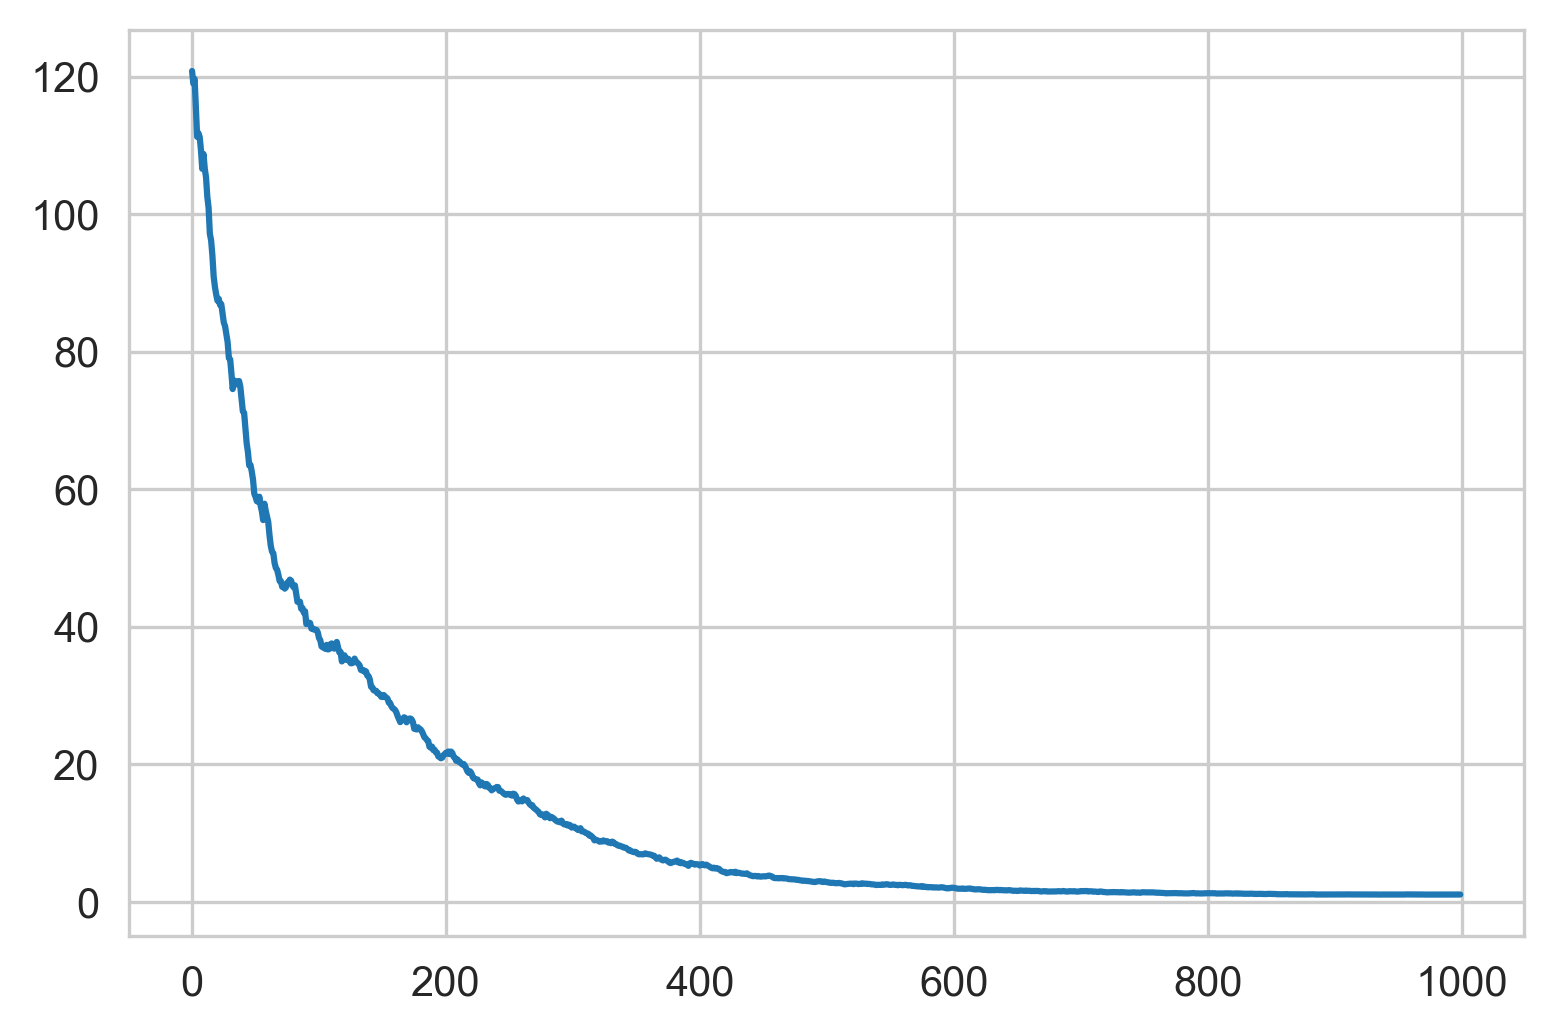

In [10]:
GE = get_ge(Database.ascad)

FILE_SUFFIX = file_suffix(None, 0)
pd.DataFrame({"Profiled SCA": GE}).to_csv(f"results/sca-ge-ascad{FILE_SUFFIX}.csv")
sns.lineplot(data=GE)